<a href="https://colab.research.google.com/github/lukas-gysin/bverl-miniproject/blob/main/notebooks/01-gyl-exploratory-data-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lukas-gysin/bverl-miniproject/blob/main/notebooks/01-gyl-exploratory-data-analysis.ipynb)

In [11]:
from io import BytesIO
from pathlib import Path
import tempfile
import zipfile

from PIL import Image
import requests
import torch

In [3]:
# Global Configuration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


## Load Dataset

In [17]:
url = 'https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1'

temp = tempfile.gettempdir()
cache = Path(temp) / 'rgb.zip'

if cache.exists():
  print('Loading RGB data from cache')
else:
  print('Loading RGB data from remote')
  res = requests.get(url, allow_redirects=True)
  cache.write_bytes(res.content)
zip_data = BytesIO(cache.read_bytes())

Loading RGB data from cache


EuroSAT_RGB/Forest/Forest_864.jpg


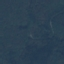

In [18]:
with zipfile.ZipFile(zip_data, 'r') as zip:
  images = [f for f in zip.namelist() if f.endswith('.jpg')]
  image = Image.open(BytesIO(zip.read(images[0])))

print(images[0])
image